## LLM

In [1]:
import torch as torch
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from transformer_kristianwold.transformer import Transformer, Inference
from transformer_kristianwold.optimization import train_step, forward_and_loss, group_decay_parameters, save_checkpoint, load_checkpoint
from transformer_kristianwold.utils import saver, loader
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)  
print("CUDA toolkit version PyTorch was built with:", torch.version.cuda)  
print("cuDNN version:", torch.backends.cudnn.version()) 
print("cuda available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

PyTorch version: 2.7.1+cu128
CUDA toolkit version PyTorch was built with: 12.8
cuDNN version: 90701
cuda available: True


## Load Data

In [2]:
tokenizer = loader("../tokenizers/cnn_tokenizer3.pkl")

## Initialize Model

In [3]:
torch.manual_seed(42)

embed_dim = 64*18
ff_dim = 4*embed_dim
heads = 18
tf_blocks = 18

model = Transformer(
    embed_dim=embed_dim,
    ff_dim=ff_dim,
    heads=heads,
    tf_blocks=tf_blocks,
    vocab_size=tokenizer.vocab_size,
    max_seq_len=1024,
    dropout=0.1,
    start_token_id=tokenizer.token_to_idx["<s>"],
    use_weight_tying=True
).to(device)

optimizer_grouped_parameters = group_decay_parameters(
    model,
    weight_decay=0.1,
    no_decay=["bias", "LayerNorm.weight"],
    )

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5)
scaler = torch.amp.GradScaler("cuda")
loss_train_list = []
loss_test_list = []

num_epochs      = 1
steps_per_epoch = 1
warmup_steps    = 1000

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

[model, 
optimizer, 
scheduler, 
loss_train_list, 
loss_test_list] = load_checkpoint("../models/checkpoint_transformer_4epoch.pth", 
                                  model, 
                                  optimizer, 
                                  scheduler, 
                                  loss_train_list, 
                                  loss_test_list)

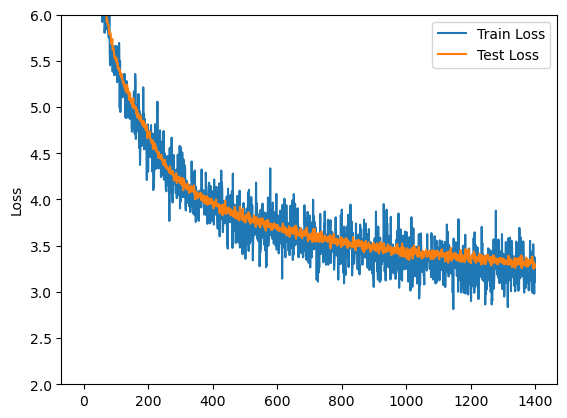

In [4]:
plt.plot(loss_train_list, label='Train Loss')
plt.plot(loss_test_list, label='Test Loss')
plt.ylim(2, 6)
plt.ylabel('Loss')
plt.legend()


In [5]:
inference = Inference(model, tokenizer, context_length=1024, device=device)

In [6]:
highlight_list = loader("../corpus/cnn_dailymail_highlight_test_cleaned.pkl")
article_list = loader("../corpus/cnn_dailymail_article_test_cleaned.pkl")

In [7]:
highlight = highlight_list[3]
article = article_list[3]

print(highlight)
print(article)

17 americans were exposed to the ebola virus while in sierra leone in march. another person was diagnosed with the disease and taken to hospital in maryland. national institutes of health says the patient is in fair condition after weeks of treatment.
(cnn)five americans who were monitored for three weeks at an omaha, nebraska, hospital after being exposed to ebola in west africa have been released, a nebraska medicine spokesman said in an email wednesday. one of the five had a heart-related issue on saturday and has been discharged but hasn't left the area, taylor wilson wrote. the others have already gone home. they were exposed to ebola in sierra leone in march, but none developed the deadly virus. they are clinicians for partners in health, a boston-based aid group. they all had contact with a colleague who was diagnosed with the disease and is being treated at the national institutes of health in bethesda, maryland. as of monday, that health care worker is in fair condition. the c

In [ ]:
text = <s><h>" + highlight + "<b>"
#text = "<s><b>" + article + "<h>"

torch.manual_seed(42)
inference.run(text, 
              T = 1, 
              k = 50)

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

In [9]:
article = """(cnn) -- u.s. government ministers and health
officials are in a high-risk area because of security concerns and fears to
avoid an outbreak of the deadly disease, the governments of liberia and sierra
leone told cnn on thursday. one person from sierra leone in the united states
was diagnosed with the virus while in sierra leone in march and died, and the
other is an american. the world health organization has said it is "deeply
concerned" by the outbreak, saying it is "completely concerned" about the risk.
"the situation has been very complex," said kevin coe, a spokesman for the world
health organization's health organization. "it is a delicate operation and is
why we look at the situation in a very wide number of countries." coe said the
most recent ebola outbreak in europe showed no signs of life in liberia. he said
the number of people infected with the ebola virus in the european union has
doubled since it first opened in may. in sierra leone, 2 people died and 5 were
taken in hospitals, said dr. charles smith, an an expert in infection at the
u.n. centers for disease control and prevention. the world health organization,
which monitors ebola in the world, is looking at a growing number. he said the
number of people with the virus who are being treated in other countries has
increased. the number of people infected with the virus in the u.n. has
increased, though it's not known whether the disease will become more widely
known. and the number of deaths of ebola in africa has dipped by nearly 15%
because it is not in the region, smith said, because of the threat from the
virus. but as the world health organization and the u.s. military have warned
against the disease, the united states, the world health organization, the world
health organization and the world health organization are "very concerned." it
said there have been more than 5,00 deaths in the first two months of the ebola
epidemic, and that more than 4.5 million people have been affected by the
infection. but on thursday, the world health organization said it had found the
number of people dying from ebola, while countries with no fatalities have
experienced high doses of the deadly virus. the number of people hospitalized
with the virus has reached a low. a public health emergency in liberia is
expected in september, with the number expected to rise by next month. but on
thursday, the world health organization said the number of cases of an ebola
attack or other serious bodily infections such as pneumonia and tubg have been
at an average of 6.5. the number of cases is rising on thursday. the ebola virus
has not spread to europe or nigeria without contact with a person who infected
with ebola. the virus was detected in guinea in march. britain has said it was
assessing and recommending its government on possible ebola travel for the
united kingdom. it is not the first time the world health organization has taken
action to raise the threat posed by ebola. in october 2008, the world health
organization said the virus was first detected in guinea in the netherlands.
then, a report found that the dutch military had detected ebola, and that it was
only in the netherlands on march 11. that report, the most common one, is to
warn "more people to avoid traveling into a different world than the
netherlands," the report says. cnn's matt smith contributed to this report."""

In [ ]:
article = article.replace("\n", " ")

In [14]:
#text = "<s><h>" + highlight + "<b>"
text = '<s><b>' + article + '<h>'

torch.manual_seed(42)
inference.run(text, 
              T = 1, 
              k = 50)

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))